In [17]:
import h5py
import numpy as np
import pandas as pd
from pandas import HDFStore
import matplotlib.pyplot as plt

In [18]:
file_location = 'C:/Users/cchang3/Downloads/Gocator/New folder/'
hdf = HDFStore(file_location+'2023.2.22.hdf5', 'r')

In [19]:
def data_concat(hdf):
    data = pd.DataFrame()
    for i in range(len(hdf.keys())):
        data = pd.concat([data, hdf[hdf.keys()[i][1:]]], axis=1)
    return data

In [20]:
def data_concat_multiple(hdf):
    Intensity_Data = pd.DataFrame()
    Profiles_Data = pd.DataFrame()
    Parameters_Data = pd.DataFrame()
    Intensity = [match for match in hdf.keys() if "Intensity" in match]
    Profiles = [match for match in hdf.keys() if "Profile" in match]
    Parameters = [match for match in hdf.keys() if "Params" in match]
    
    for i in range(len(Intensity)):
        Intensity_Data = pd.concat([Intensity_Data, hdf[Intensity[i]]], axis=0)
    for i in range(len(Profiles)):
        Profiles_Data = pd.concat([Profiles_Data, hdf[Profiles[i]]], axis=0)
    for i in range(len(Parameters)):
        Parameters_Data = pd.concat([Parameters_Data, hdf[Parameters[i]]], axis=1)
    
    Parameters_Data.index = np.arange(0,len(Parameters_Data.index),1)
    Parameters_Data.columns = np.arange(0, len(Parameters_Data.columns),1)
    Intensity_Data.index = np.arange(0,len(Intensity_Data.index),1)*Parameters_Data.iloc[2][0]
    Intensity_Data.columns = np.arange(0, len(Intensity_Data.columns),1)*0.3925
    Profiles_Data.index = np.arange(0,len(Profiles_Data.index),1)*Parameters_Data.iloc[2][0]
    Profiles_Data.columns = np.arange(0, len(Profiles_Data.columns),1)*0.3925

    return Intensity_Data, Profiles_Data, Parameters_Data

In [21]:
I,P,Param = data_concat_multiple(hdf)
Profiles = Param[0][4]*P+Param[0][7]
Intensity = I

In [29]:
#half
Intensity_cut=Intensity.iloc[:,:int(len(Intensity.columns)/2)]
Profiles_cut=Profiles.iloc[int(len(Profiles.index)/2):,:]
Intensity.shape

(2292, 910)

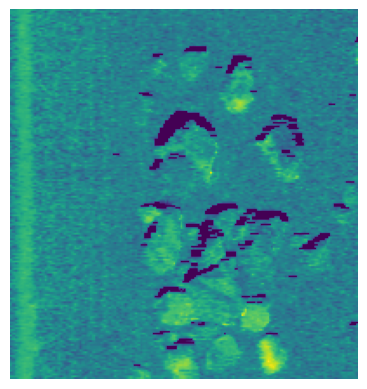

In [51]:
Ystart=880
Yend=1080
Xstart=0
Xend=200
df=Intensity.iloc[Ystart:Yend,Xstart:Xend]
data = df.values

plt.figure()
plt.axis('off') 
plt.margins(0,0)
plt.imshow(data, extent=[Intensity.columns[Xstart], Intensity.columns[Xend-1],Intensity.index[Ystart], Intensity.index[Yend-1]])
plt.savefig('2023.5.22.800_1080_0_200.png',transparent=True,bbox_inches='tight',pad_inches = -0.1,dpi=600)
plt.show() 